In [4]:
!pip install nltk

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [177]:
import nltk
import re
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import itertools
import string
%matplotlib inline

# Fetch dataset
df = pd.read_csv('https://s3-us-west-2.amazonaws.com/patchworks-coding-challenge/amazon_alexa.tsv', sep='\t')


In [178]:
df

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1
8,5,30-Jul-18,Heather Gray Fabric,looks great,1
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1


In [179]:
df['text length'] = df['verified_reviews'].apply(len)
df['verified_reviews'] = df['verified_reviews'].apply(text_process)

/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


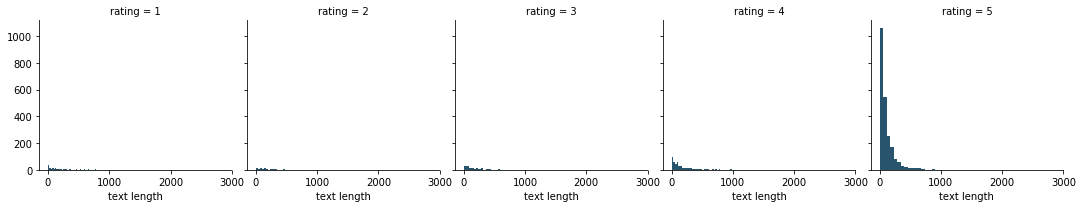

In [180]:
g = sns.FacetGrid(data=df, col='rating')
g.map(plt.hist, 'text length', bins=50, color='#28546E')
plt.savefig('rating_textlen', dpi=200)

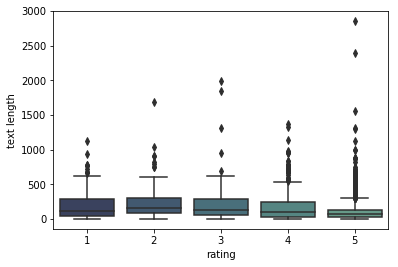

In [181]:
sns.boxplot(x='rating', y='text length', data=df, palette=sns.cubehelix_palette(9, start=.4, rot=-.70, reverse=True, light=0.85, dark=0.25))
plt.savefig('stars_textlen_box', dpi=200)

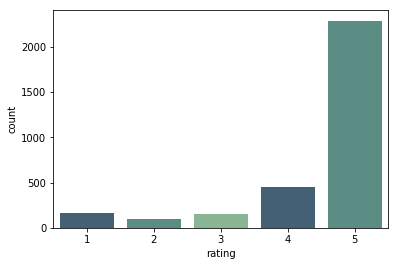

In [182]:
sns.countplot(x='rating', data=df, palette=sns.cubehelix_palette(3, start=.4, rot=-.70, reverse=True, light=0.65, dark=0.35))


In [ ]:
df['verified_reviews'] = df['verified_reviews'].apply(lambda x:re.sub(r'\W+', " ",x))
df['verified_reviews'] = df['verified_reviews'].apply(lambda x:x.lower())

df['rating']  = df['rating'].apply(lambda x: 0 if (x==1 or x==2) else 1)

In [183]:
def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in text if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [184]:
print(text_process("Hey there! This is a sample review, which happens to contain punctuations."))


['Hey', 'sample', 'review', 'happens', 'contain', 'punctuations']


In [185]:
df_class = df
X = df_class['verified_reviews']
y = df_class['rating']

In [186]:
from sklearn.feature_extraction.text import CountVectorizer


In [187]:
bow_transformer = CountVectorizer(analyzer=text_process).fit(X)


/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [188]:
# Print total number of vocab words
print(len(bow_transformer.vocabulary_))

2223


In [189]:
X = bow_transformer.transform(X)


/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:15: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


In [190]:
from sklearn.model_selection import train_test_split


In [191]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)


In [192]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [193]:
nb.fit(X_train, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [194]:
preds = nb.predict(X_test)


In [195]:
from sklearn.metrics import confusion_matrix, classification_report


In [196]:
print(confusion_matrix(y_test, preds))
print('\n')
print(classification_report(y_test, preds))

[[  0   0   0   0  38]
 [  0   0   0   0  32]
 [  0   0   0   0  54]
 [  0   0   0   0 127]
 [  0   0   0   0 694]]


              precision    recall  f1-score   support

           1       0.00      0.00      0.00        38
           2       0.00      0.00      0.00        32
           3       0.00      0.00      0.00        54
           4       0.00      0.00      0.00       127
           5       0.73      1.00      0.85       694

   micro avg       0.73      0.73      0.73       945
   macro avg       0.15      0.20      0.17       945
weighted avg       0.54      0.73      0.62       945



/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dinodjakovac/anaconda2/envs/gl-env/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [197]:
df

,rating,date,variation,verified_reviews,feedback,text length
0,5,31-Jul-18,Charcoal Fabric,"[Love, Echo]",1,13
1,5,31-Jul-18,Charcoal Fabric,[Loved],1,9
2,4,31-Jul-18,Walnut Finish,"[Sometimes, playing, game, answer, question, c...",1,195
3,5,31-Jul-18,Charcoal Fabric,"[lot, fun, thing, 4, yr, old, learns, dinosaur...",1,172
4,5,31-Jul-18,Charcoal Fabric,[Music],1,5
5,5,31-Jul-18,Heather Gray Fabric,"[received, echo, gift, needed, another, Blueto...",1,174
6,3,31-Jul-18,Sandstone Fabric,"[Without, cellphone, cannot, use, many, featur...",1,365
7,5,31-Jul-18,Charcoal Fabric,"[think, 5th, one, Ive, purchased, Im, working,...",1,221
8,5,30-Jul-18,Heather Gray Fabric,"[looks, great]",1,11
9,5,30-Jul-18,Heather Gray Fabric,"[Love, I’ve, listened, songs, haven’t, heard, ...",1,120
